# Weather Forecasting with LSTM for the next 2 days



In [140]:
!python --version

Python 3.9.18


# Prepare the data

In [141]:
import pandas as pd
# Have a look at the data
df = pd.read_csv('data\Environment variables-data-as-seriestocolumns-2022-03-01 16_36_12.csv')
df.shape


(62724, 4)

In [142]:
df.head()

,Time,TF.insideEnvironment.insideHumidity,TF.insideEnvironment.insideLight,TF.insideEnvironment.insideTemperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


In Excel I had a look over the data and saw lots of duplicates and missing values. I will have to clean the data before I can work with it.

In [143]:
df.drop_duplicates(inplace=True)
df.shape

(43471, 4)

In [144]:
# count the duplicates that are left
df.duplicated().sum()

0

In [1]:
df.info()

NameError: name 'df' is not defined

So we have a different amount of data points for each column. We will have to interpolate the data to get a consistent dataset.
But first lets rename the columns to make them more readable.

In [146]:
#rename the columns
df.columns = ['Time', 'Humidity', 'Light', 'Temperature']
df.head()

,Time,Humidity,Light,Temperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


# Visualize the data, Interpolating

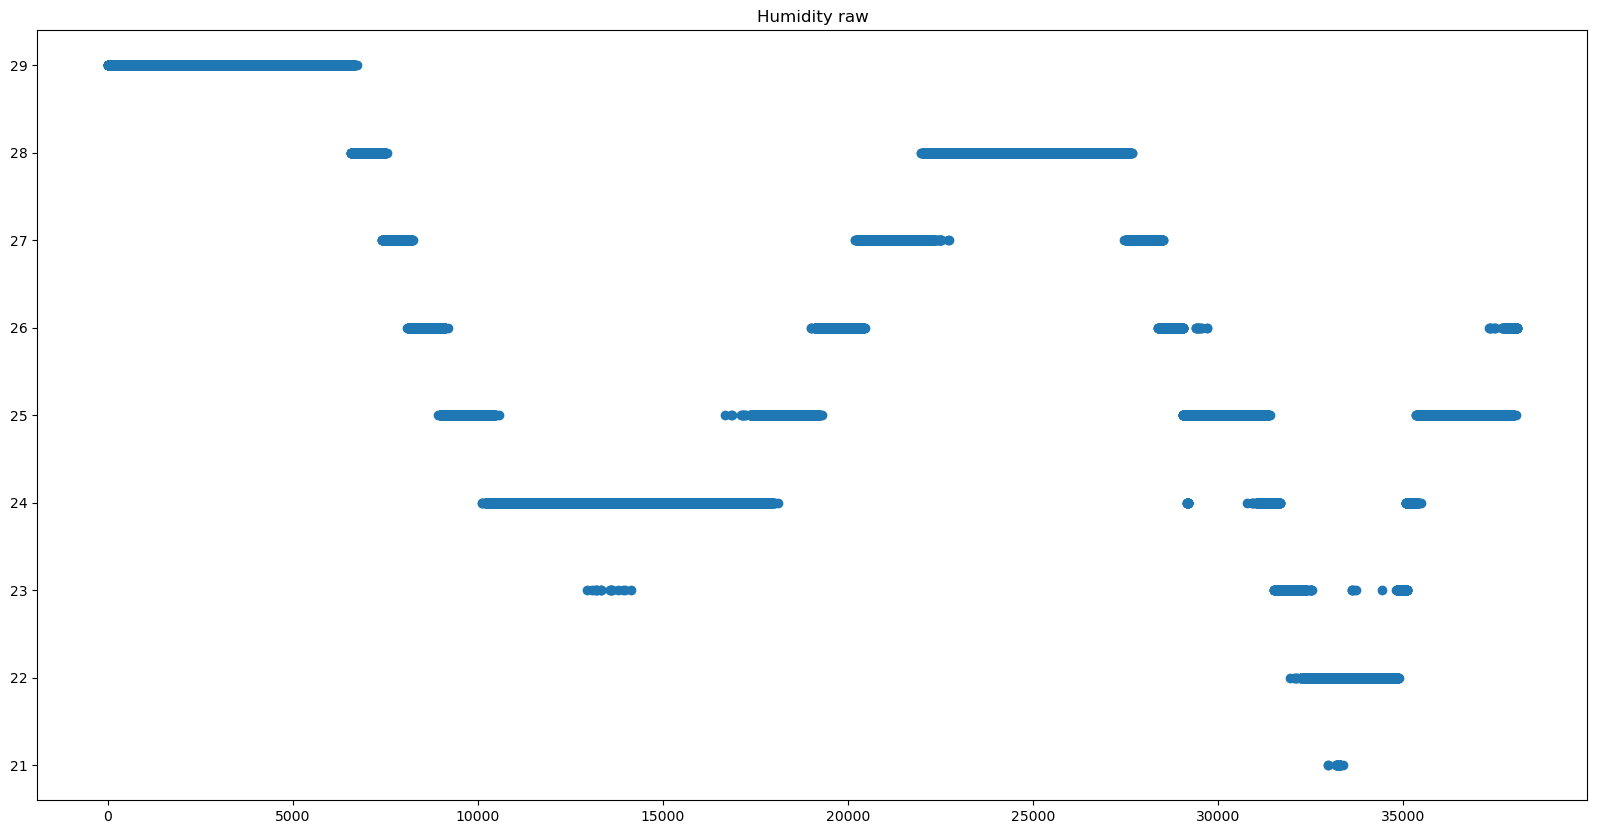

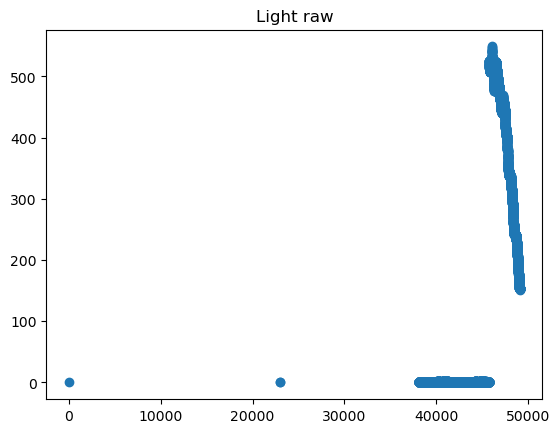

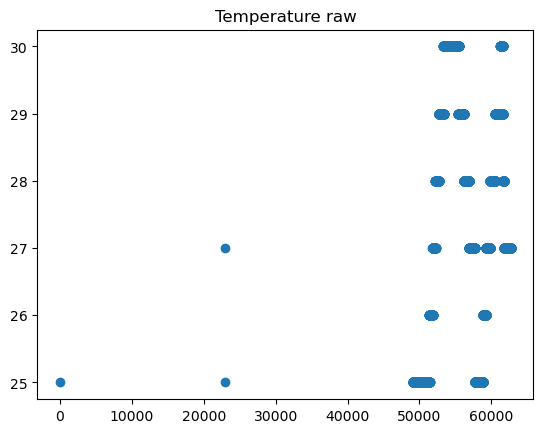

In [147]:
# import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity raw')
plt.show()
plt.plot(df['Light'], marker='o', linestyle='', label='Light')
plt.title('Light raw')
plt.show()
plt.plot(df['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature raw')
plt.show()

In [148]:
# to be able to use method 'time' we need to convert the Time column to datetime
df['Time'] = pd.to_datetime(df['Time'])
# set the Time column as index
df.set_index('Time', inplace=True)

# interpolate the data
df_ip = df.copy()
df_ip.interpolate(method='time', inplace=True)
df_ip.head()


,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:05,29.0,0.140149,25.0
2022-02-28 06:00:06,29.0,0.140186,25.0
2022-02-28 06:00:11,29.0,0.140372,25.0


In [149]:
# resample the data to have a consistent time interval
step_width_min = 5
df_ip = df_ip.resample(f'{step_width_min}min').mean()
df_ip.loc['2022-02-28']

,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:00,29.0,0.145460,25.0
2022-02-28 06:05:00,29.0,0.156587,25.0
2022-02-28 06:10:00,29.0,0.168338,25.0
2022-02-28 06:15:00,29.0,0.179095,25.0
2022-02-28 06:20:00,29.0,0.189160,25.0
...,...,...,...
2022-02-28 23:35:00,NaN,NaN,NaN
2022-02-28 23:40:00,NaN,NaN,NaN
2022-02-28 23:45:00,NaN,NaN,NaN


In [150]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2022-02-28 06:00:00 to 2022-03-01 16:30:00
Freq: 5min
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Humidity     320 non-null    float64
 1   Light        320 non-null    float64
 2   Temperature  320 non-null    float64
dtypes: float64(3)
memory usage: 13.0 KB


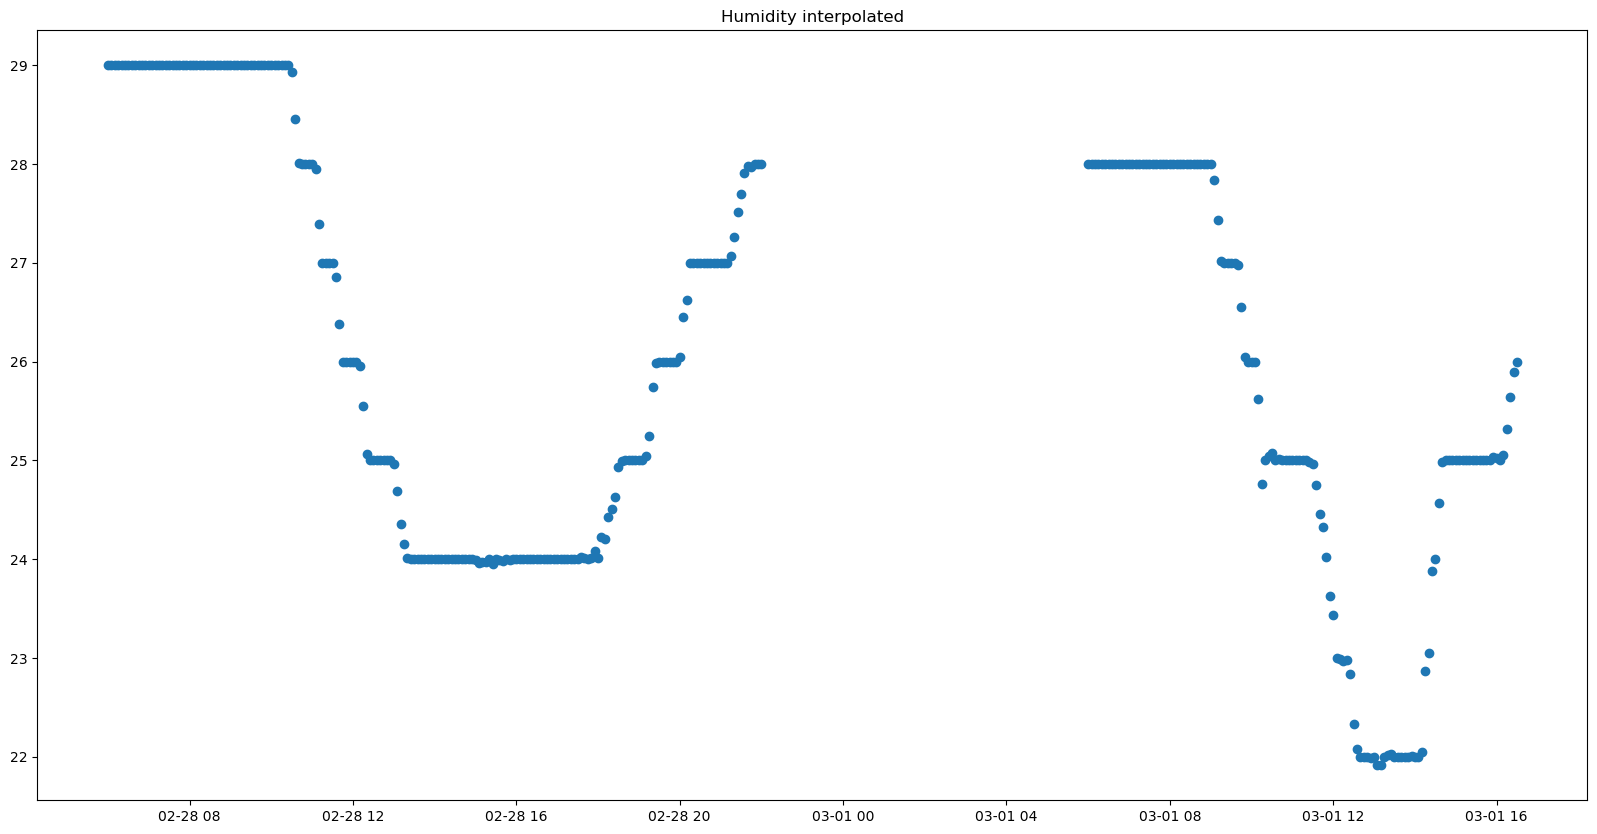

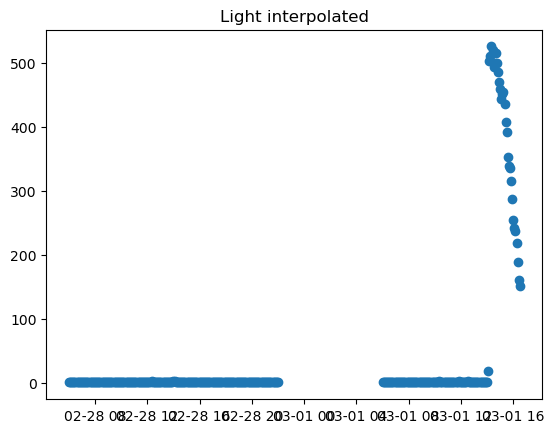

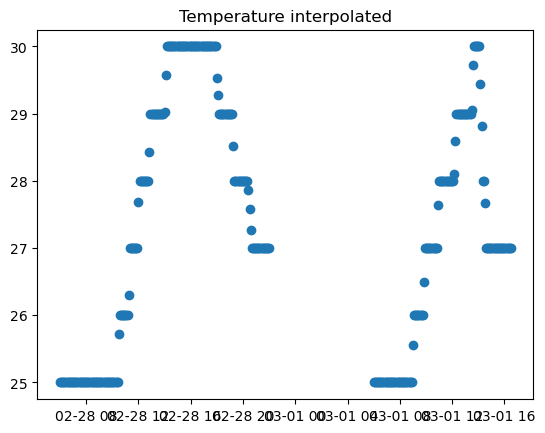

In [151]:
plt.figure(figsize=(20,10))
plt.plot(df_ip['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity interpolated')
plt.show()
plt.plot(df_ip['Light'], marker='o', linestyle='', label='Humidity')
plt.title('Light interpolated')
plt.show()
plt.plot(df_ip['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature interpolated')
plt.show()

The interpolated data looks much better. Still weird, that we have this gap in the data. But at least it's a consistent gap.

In [152]:
df_ip.describe()

,Humidity,Light,Temperature
count,320.000000,320.000000,320.000000
mean,25.986044,35.631456,27.315265
std,2.146955,116.130868,1.830944
min,21.913907,0.082268,25.000000
25%,24.000000,0.254867,25.000000
50%,25.688422,0.990193,27.000000
75%,28.000000,1.313316,29.000000
max,29.000000,526.298925,30.000000


Filling the gap: The gap looks like it is from 2022-02-28 00:00:00 to 2022-02-28 23:30:00. Before and after this gap the data is consistent and it's at night when the shopfloor might be closed. So we will interpolate them to create a smooth transition.

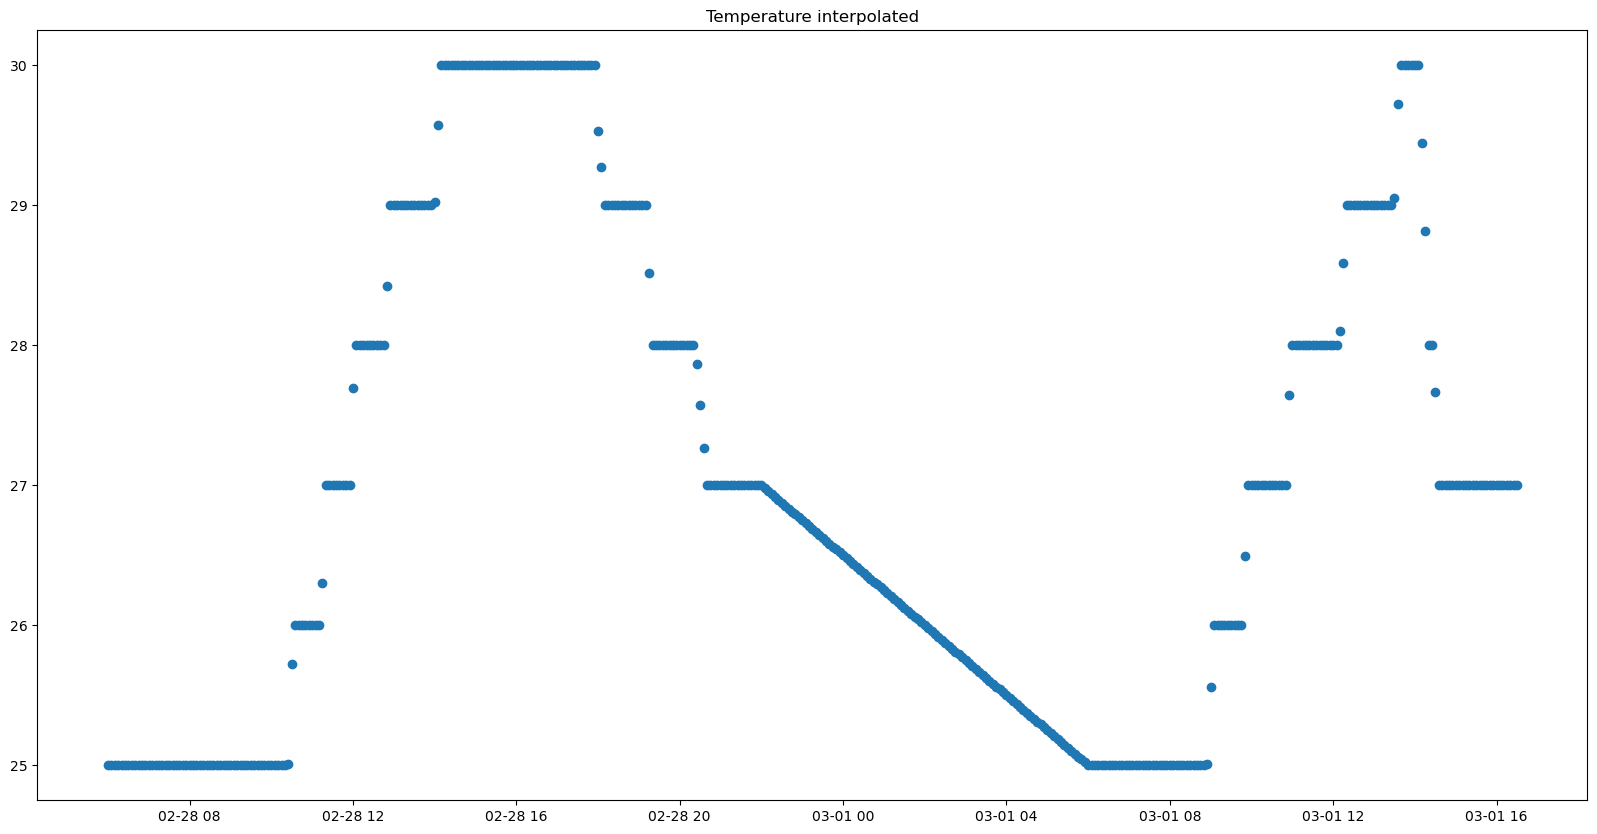

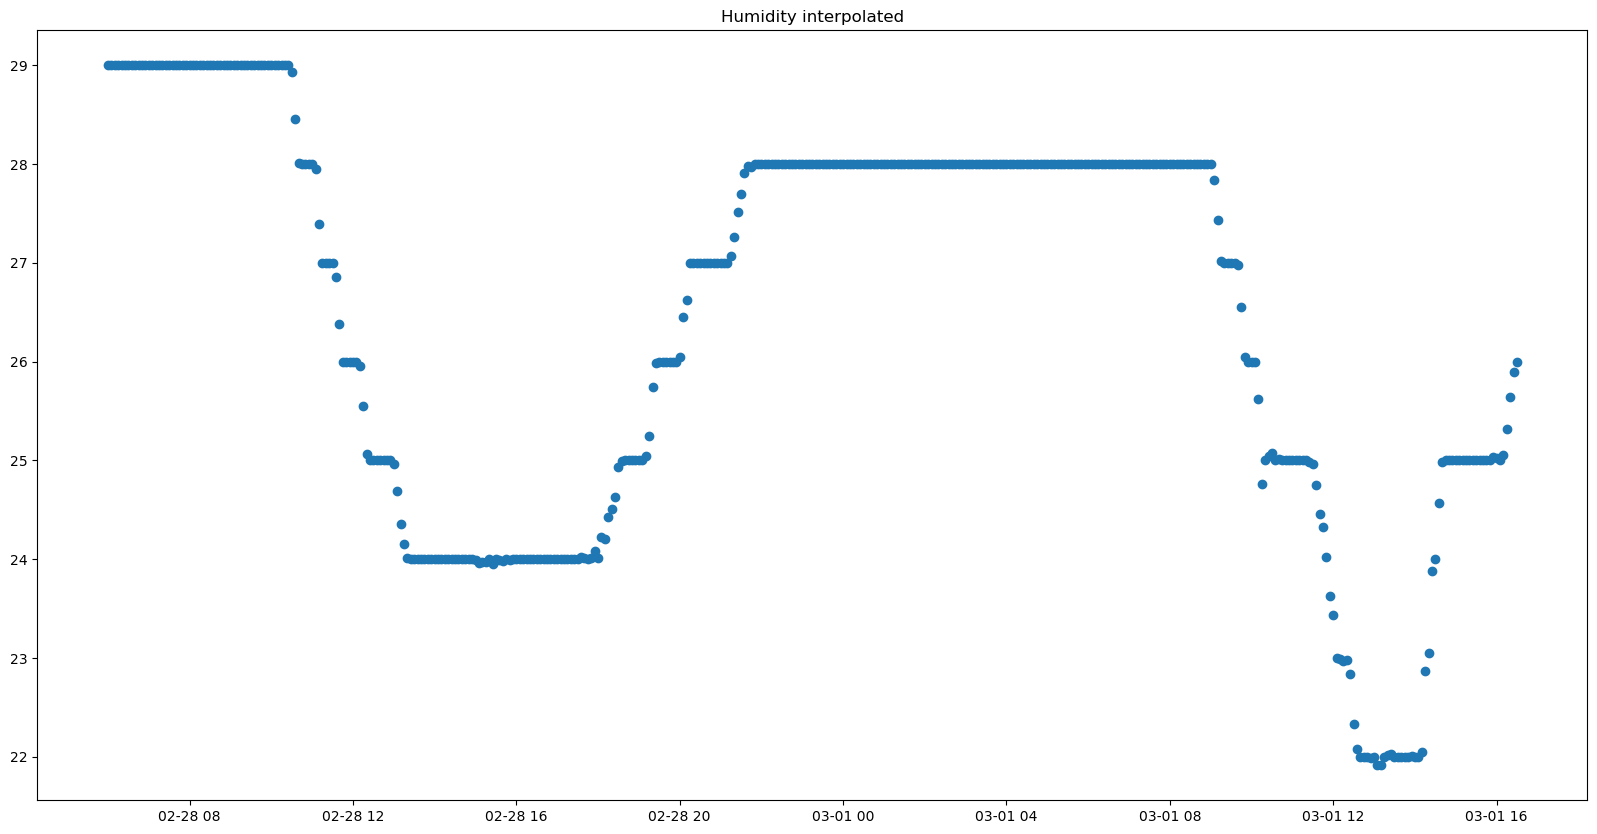

In [204]:
# using method 'linear' because the timestamps are evenly spaced
df_ip.interpolate(method='linear', inplace=True)
plt.figure(figsize=(20,10))
plt.plot(df_ip['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature interpolated')
plt.show()
plt.figure(figsize=(20,10))
plt.plot(df_ip['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity interpolated')
plt.show()

# Preparing the data for the model

Usualle for lagged features we would use a seasonal unit where the smallest is a day. Because we only have two days of data we then would not have enough data points for the model. So I decided that we use an hour as a unit.

In [154]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
# get rid of the light data
df_ip.drop(columns='Light', inplace=True)
scaler = MinMaxScaler()
df_ip_scaled = pd.DataFrame(scaler.fit_transform(df_ip), columns=df_ip.columns, index=df_ip.index)
#df_ip_scaled = scaler.fit_transform(df_ip)
# data unscaled
print(df_ip.head)
# data scaled
print(df_ip_scaled.head)

<bound method NDFrame.head of                       Humidity  Temperature
Time                                       
2022-02-28 06:00:00  29.000000         25.0
2022-02-28 06:05:00  29.000000         25.0
2022-02-28 06:10:00  29.000000         25.0
2022-02-28 06:15:00  29.000000         25.0
2022-02-28 06:20:00  29.000000         25.0
...                        ...          ...
2022-03-01 16:10:00  25.055172         27.0
2022-03-01 16:15:00  25.319476         27.0
2022-03-01 16:20:00  25.637500         27.0
2022-03-01 16:25:00  25.892929         27.0
2022-03-01 16:30:00  26.000000         27.0

[415 rows x 2 columns]>
<bound method NDFrame.head of                      Humidity  Temperature
Time                                      
2022-02-28 06:00:00  1.000000          0.0
2022-02-28 06:05:00  1.000000          0.0
2022-02-28 06:10:00  1.000000          0.0
2022-02-28 06:15:00  1.000000          0.0
2022-02-28 06:20:00  1.000000          0.0
...                       ...          ...

In [155]:
# add sin and cos to let the model learn the seasonality of days
import numpy as np

df_ip_scaled['Seconds'] = df_ip_scaled.index.map(pd.Timestamp.timestamp)
sec_in_day = 60*60*24
df_ip_scaled['Day sin'] = np.sin(df_ip_scaled['Seconds'] * (2* np.pi / sec_in_day))
df_ip_scaled['Day cos'] = np.cos(df_ip_scaled['Seconds'] * (2 * np.pi / sec_in_day))
# safe seconds for prediction later on
df_seconds = df_ip_scaled['Seconds']
df_ip_scaled.drop(columns='Seconds', inplace=True)
df_ip_scaled

,Humidity,Temperature,Day sin,Day cos
Time,,,,
2022-02-28 06:00:00,1.000000,0.0,1.000000,9.282962e-12
2022-02-28 06:05:00,1.000000,0.0,0.999762,-2.181489e-02
2022-02-28 06:10:00,1.000000,0.0,0.999048,-4.361939e-02
2022-02-28 06:15:00,1.000000,0.0,0.997859,-6.540313e-02
2022-02-28 06:20:00,1.000000,0.0,0.996195,-8.715574e-02
...,...,...,...,...
2022-03-01 16:10:00,0.443300,0.4,-0.887011,-4.617486e-01
2022-03-01 16:15:00,0.480599,0.4,-0.896873,-4.422887e-01
2022-03-01 16:20:00,0.525479,0.4,-0.906308,-4.226183e-01


In [156]:
import numpy as np

def create_sequences(data, n_timesteps):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        # Input sequence (last n_timesteps of humidity, light, temperature)
        X.append(data[i:i + n_timesteps])
        # Target (humidity and temperature for the next timestep)
        y.append(data.iloc[i+n_timesteps][['Humidity', 'Temperature']])  # 0 for humidity, 2 for temperature
    return np.array(X), np.array(y)

n_timesteps = 12  # Use past 12 time steps (1 Hour) to predict the next step
X_scaled, y_scaled = create_sequences(df_ip_scaled, n_timesteps)

print(X_scaled.shape)
print(X_scaled[0])
print(y_scaled.shape)
print(y_scaled[0])

(403, 12, 4)
[[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  9.28296189e-12]
 [ 1.00000000e+00  0.00000000e+00  9.99762027e-01 -2.18148850e-02]
 [ 1.00000000e+00  0.00000000e+00  9.99048222e-01 -4.36193874e-02]
 [ 1.00000000e+00  0.00000000e+00  9.97858923e-01 -6.54031292e-02]
 [ 1.00000000e+00  0.00000000e+00  9.96194698e-01 -8.71557427e-02]
 [ 1.00000000e+00  0.00000000e+00  9.94056338e-01 -1.08866875e-01]
 [ 1.00000000e+00  0.00000000e+00  9.91444861e-01 -1.30526192e-01]
 [ 1.00000000e+00  0.00000000e+00  9.88361510e-01 -1.52123386e-01]
 [ 1.00000000e+00  0.00000000e+00  9.84807753e-01 -1.73648178e-01]
 [ 1.00000000e+00  0.00000000e+00  9.80785280e-01 -1.95090322e-01]
 [ 1.00000000e+00  0.00000000e+00  9.76296007e-01 -2.16439614e-01]
 [ 1.00000000e+00  0.00000000e+00  9.71342070e-01 -2.37685892e-01]]
(403, 2)
[1. 0.]


In [157]:
# create the test and train set
TEST_SPLIT = 0.1

#data = data.drop(columns = ['Wind', 'Solar'])
train_size = int(len(X_scaled) * (1-TEST_SPLIT))
test_size = len(X_scaled) - train_size

X_scaled_train = X_scaled[0:train_size]
X_scaled_test = X_scaled[train_size:len(y_scaled)]
y_scaled_train = y_scaled[0:train_size]
y_scaled_test = y_scaled[train_size:len(y_scaled)]


# Create the Model and train it

In [158]:
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((n_timesteps, 4))) # 3 features
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(2, 'linear'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17664     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18,202
Trainable params: 18,202
Non-trainable params: 0
_________________________________________________________________


In [159]:
cp = ModelCheckpoint('models/model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [160]:
model.fit(X_scaled_train, y_scaled_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[cp])

Epoch 1/50
11/11 [==============================] - 3s 69ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1856
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0480 - root_mean_squared_error: 0.2192 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 3/50
11/11 [==============================] - 0s 16ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 4/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0178 - val_root_mean

In [161]:
from keras.models import load_model
model = load_model('models/model.h5')

(41, 12, 4)
[[ 1.51873786e-01  6.19782471e-01 -4.36193874e-02 -9.99048222e-01]
 [ 1.49089650e-01  7.17819805e-01 -6.54031292e-02 -9.97858923e-01]
 [ 1.50837899e-01  8.00000000e-01 -8.71557427e-02 -9.96194698e-01]
 [ 1.29813920e-01  8.00000000e-01 -1.08866875e-01 -9.94056338e-01]
 [ 5.88801836e-02  8.00000000e-01 -1.30526192e-01 -9.91444861e-01]
 [ 2.35508739e-02  8.00000000e-01 -1.52123386e-01 -9.88361510e-01]
 [ 1.21495327e-02  8.00000000e-01 -1.73648178e-01 -9.84807753e-01]
 [ 1.21495327e-02  8.00000000e-01 -1.95090322e-01 -9.80785280e-01]
 [ 1.21495327e-02  8.00000000e-01 -2.16439614e-01 -9.76296007e-01]
 [ 1.00432417e-02  8.00000000e-01 -2.37685892e-01 -9.71342070e-01]
 [ 1.21495327e-02  8.00000000e-01 -2.58819045e-01 -9.65925826e-01]
 [ 5.97551898e-04  8.00000000e-01 -2.79829014e-01 -9.60049854e-01]]
2/2 [==============================] - 0s 3ms/step


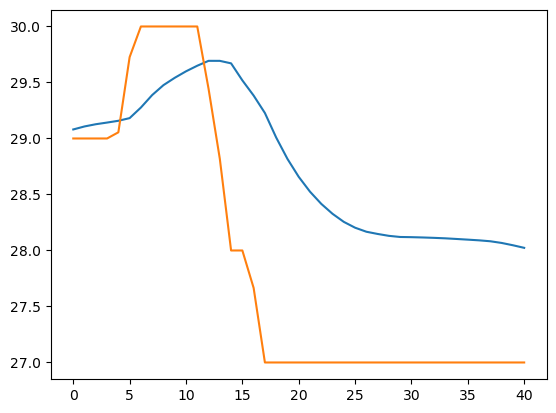

In [187]:
# plot the test data
def plot_predictions(model, X, y, start=0, end=100):
    y_predictions_scaled = model.predict(X)
    # rescale the data
    y_predictions = scaler.inverse_transform(y_predictions_scaled)
    df_y_predictions = pd.DataFrame(y_predictions)
    y_actuals = scaler.inverse_transform(y)
    df_y_actuals = pd.DataFrame(y_actuals)
    df = pd.DataFrame(data={'Predictions humidity':df_y_predictions[1], 'Actuals humdity':df_y_actuals[0], 'Predictions temperature':df_y_predictions[1], 'Actuals temperature': df_y_actuals[1] })
    plt.plot(df['Predictions temperature'][start:end], label='Prediction')
    plt.plot(df['Actuals temperature'][start:end], label='Actual')
    return df

print(X_scaled_test.shape)
print(X_scaled_test[0])
df = plot_predictions(model, X_scaled_test, y_scaled_test)

The model seems to be able to predict the temperature quite well. The humidity is not as good.
# Make predictions for the next 2 days

In [206]:
# make predictions for the next 2 days 
# calc number of steps to make
future_steps = 48*(int(60/step_width_min))
print(future_steps)
# create input for first step
last_sequence = X_scaled[-1].reshape((1, n_timesteps, 4))
predictions = []
seconds_last = df_seconds.iloc[-1]

for step in range(future_steps):
    prediction_scaled = model.predict(last_sequence)
    seconds_last += step_width_min * 60
    prediction = scaler.inverse_transform(prediction_scaled)
    np_seconds = np.array(seconds_last)
    predictions_entry = (seconds_last, prediction[0][0], prediction[0][1])
    predictions.append(predictions_entry)
    # calculate sin and cos
    sin = np.sin(seconds_last * (2* np.pi / sec_in_day))
    cos = np.cos(seconds_last * (2* np.pi / sec_in_day))
    next_step = np.hstack((prediction_scaled[0], sin, cos))
    last_sequence = np.concatenate((last_sequence[:, 1:, :], next_step.reshape(1, 1, next_step.shape[0])), axis=1)


576
1/1 [==============================] - 0s 17ms/step


In [207]:
# create a dataframe with the predictions
df_predictions = pd.DataFrame(predictions, columns=['Seconds', 'Humidity', 'Temperature'])
df_predictions['Time'] = pd.to_datetime(df_predictions['Seconds'], unit='s')
df_predictions.set_index('Time', inplace=True)
df_predictions.drop(columns='Seconds', inplace=True)
df_predictions.head()

,Humidity,Temperature
Time,,
2022-03-01 16:35:00,25.231689,28.023594
2022-03-01 16:40:00,25.250450,28.154140
2022-03-01 16:45:00,25.261393,28.264965
2022-03-01 16:50:00,25.265848,28.371164
2022-03-01 16:55:00,25.265678,28.472080


# Visualize the predictions

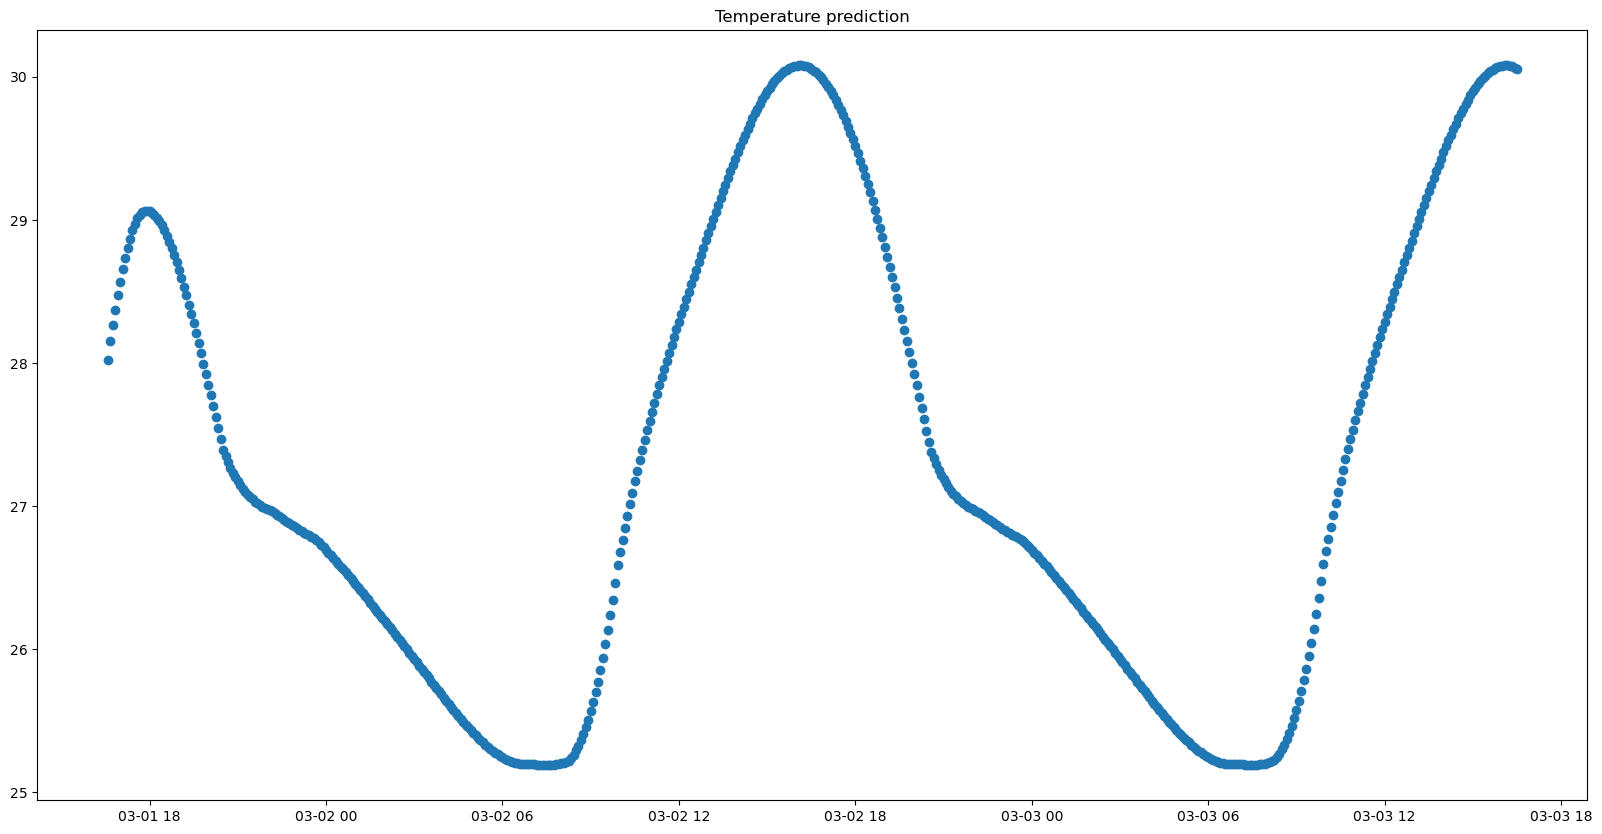

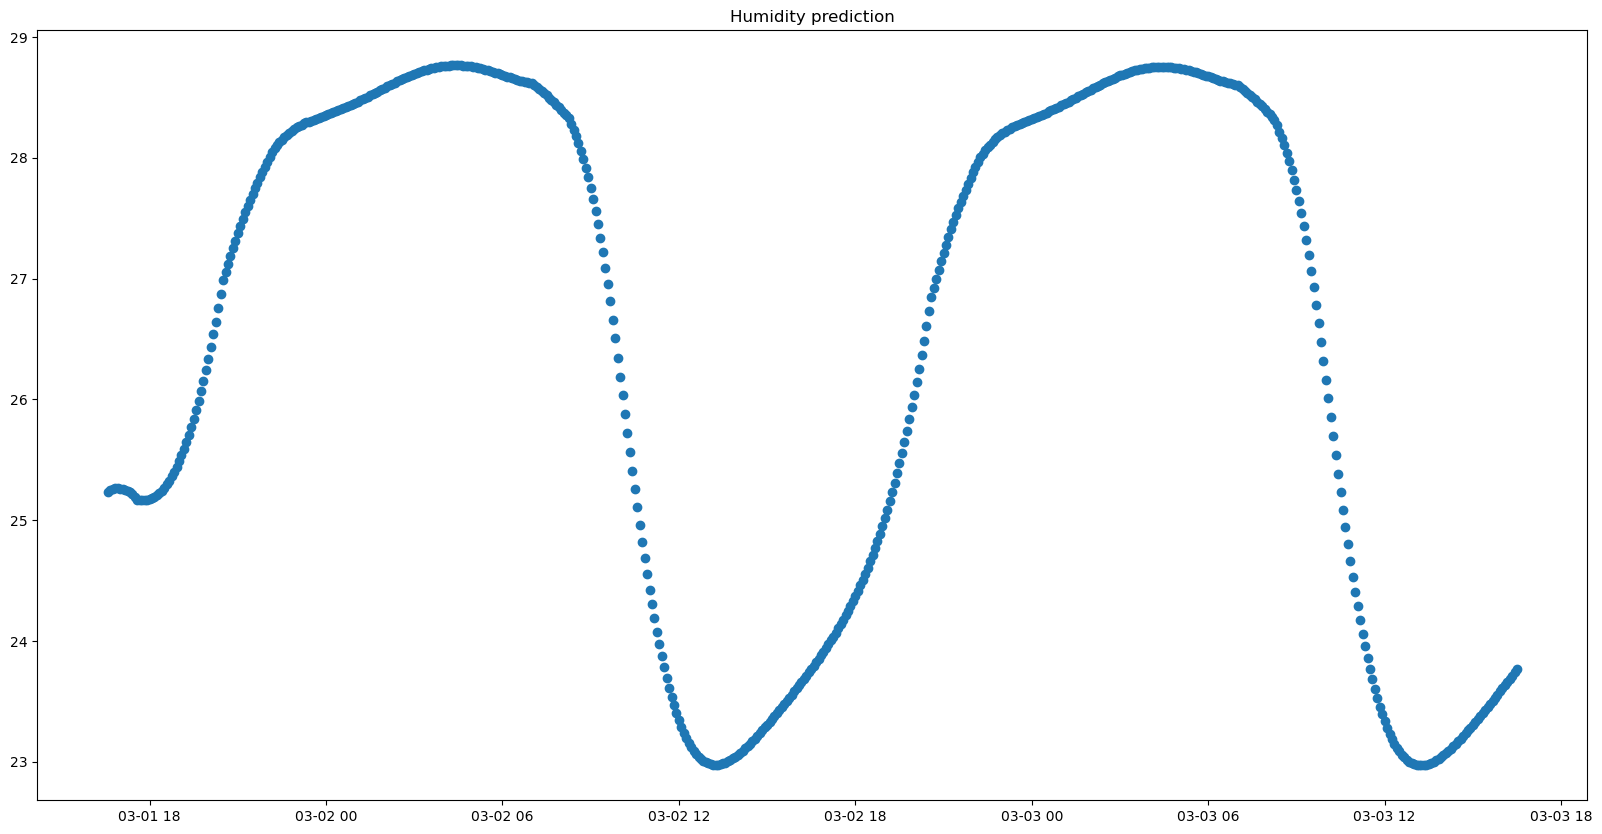

In [208]:
# plot the predictions
plt.figure(figsize=(20,10))
plt.plot(df_predictions['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature prediction')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(df_predictions['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity prediction')
plt.show()